# Lorenz System
$$\frac{dx}{dt} = \sigma(y-x) \\ \frac{dy}{dt} = x(\rho-z)-y \\ \frac{dz}{dt} = xy-\beta z$$




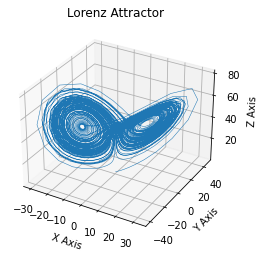

In [4]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

rho = 45.92
sigma = 16.0
beta = 8.0 / 2.0

def lorenz_equation(xyz,t):
    x, y, z = xyz  
    dx = sigma*(y - x)
    dy = rho*x - y - x*z
    dz = x*y - beta*z
    return dx, dy, dz

t = np.linspace(0,200,10000)
init = [0,1,1.05]

def lorenz(t, init):
    return odeint(lorenz_equation, init, t)

sol = lorenz(t,init)
t_describe = t[:3000]
sol_describe = sol[:3000,:]
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*sol_describe.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

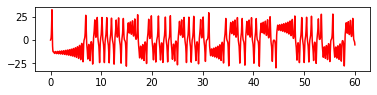

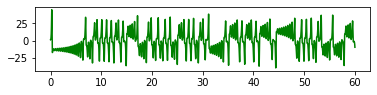

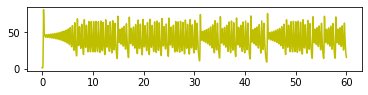

In [5]:
plt.subplot(3, 1, 1)                # nrows=2, ncols=1, index=1
plt.plot(t_describe, sol_describe[:, 0], 'r', label='x')
plt.show()
plt.subplot(3, 1, 2)
plt.plot(t_describe, sol_describe[:, 1], 'g', label='y')
plt.show()
plt.subplot(3, 1, 3)
plt.plot(t_describe, sol_describe[:, 2], 'y', label='z')
plt.show()

# Training Dynamical Systems with RNN

Reference: Recurrent Neural Networks for Dynamical Systems: Applications to Ordinary
Differential Equations, Collective Motion, and Hydrological Modeling

In [6]:
train_size = 5000
test_size = 40
sol_train = sol[:-test_size]
dim = np.shape(sol_train)[1]
y = torch.tensor(sol_train).to(torch.float32)

In [7]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [9]:
window_size = test_size
train_data = input_data(train_set, window_size)

In [14]:
class RNN(nn.Module):
    
  def __init__(self,input_size = dim, hidden_size = 128, num_layers = 3, out_size = dim):
    super().__init__()
    self.hidden_size = hidden_size
    self.window_size = 40
    self.num_layers = num_layers
    self.hidden = torch.zeros(num_layers,1 , hidden_size)

    self.RNN_cell = nn.RNN(input_size, hidden_size, num_layers)
    self.linear = nn.Linear(hidden_size,out_size)
    
  def forward(self,seq):
    self.out = seq.view(self.window_size,1,-1)
    # Unfolding LSTM
    RNN_out, hidden = self.RNN_cell(seq.view(self.window_size,1,-1), self.hidden)

    pred = self.linear(RNN_out.view(len(seq),-1))

    return pred



In [15]:
torch.manual_seed(42)
model = RNN()
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
model

RNN(
  (RNN_cell): RNN(3, 128, num_layers=3)
  (linear): Linear(in_features=128, out_features=3, bias=True)
)

In [16]:
epochs = 100
future = test_size
loss_list = []
for epoch in range(epochs):
    i = 0
    for seq, y_train in train_data:
      percentage = i/len(train_data) * 100
      if percentage % 10 == 0:
        print('Epoch:'+str(epoch) +' , ' + str(percentage)+'%')
      i += 1
      
      optimizer.zero_grad()
      model.hidden = torch.zeros(model.num_layers,1,model.hidden_size)
      y_pred = model(seq)
      loss = criterion(y_pred, y_train)
      loss.backward()
      optimizer.step()

        
    print(f"Epoch {epoch} Loss: {loss.item()}")
    
    for f in range(future):
        seq = torch.FloatTensor(train_set[-test_size:])
        preds = train_set[-test_size:].tolist()
        with torch.no_grad():
          model.hidden = torch.zeros(model.num_layers,1,model.hidden_size)
          preds.append(model(seq)[f])

    preds = torch.tensor(preds)   
    loss = criterion(torch.tensor(preds[-test_size:]), y[-test_size:])
    loss_list.append(loss)
    print(f"Performance on test range: {loss}")
    
    if epoch % 1 == 0:
      plt.plot(loss_list,'o-')
      plt.title('Loss Graph')
      plt.show()

      plt.subplot(3, 1, 1)                
      plt.plot(t[-5*test_size:], sol[-5*test_size:, 0], 'r', label='x')
      plt.plot(t[-test_size :], preds[-test_size :,0], '-b', label='predicted_x')
      plt.show()

      plt.subplot(3, 1, 2)
      plt.plot(t[-5*test_size:], sol[-5*test_size:, 1], 'g', label='y')
      plt.plot(t[-test_size :], preds[-test_size :,1], '-b', label='predicted_x')
      plt.show()

      plt.subplot(3, 1, 3)
      plt.plot(t[-5*test_size:], sol[-5*test_size:, 2], 'y', label='z')
      plt.plot(t[-test_size :], preds[-test_size :,2], '-b', label='predicted_x')
      plt.show()


Epoch:0 , 0.0%


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([40, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:0 , 10.0%


KeyboardInterrupt: ignored

In [17]:
np.shape(seq)

torch.Size([40, 3])

In [ ]:
preds = train_set[-test_size:].tolist()
preds.append(model(seq).tolist())

AxisError: ignored

In [ ]:
preds[40]

[[0.11795026063919067, -10.405400276184082, 58.895023345947266],
 [77.47837829589844, -24.267513275146484, 92.75509643554688],
 [-45.97629165649414, -7.338884353637695, 57.00619888305664],
 [127.0098648071289, -85.5954360961914, 481.9065246582031],
 [-397.4962158203125, -611.580078125, -565.73388671875],
 [-1106.9488525390625, -2633.206787109375, 791.3037109375],
 [2908.763916015625, -8233.6220703125, 5795.111328125],
 [-5803.03271484375, -550.6361083984375, 1876.6549072265625],
 [-7294.91845703125, -22094.087890625, 30550.10546875],
 [-4884.48876953125, -69.87659454345703, 19119.095703125],
 [-15831.1904296875, -2742.145263671875, -5449.1611328125],
 [-85045.859375, -5291.4111328125, 40628.59765625],
 [-87830.6484375, -65020.32421875, 73320.2734375],
 [97943.7421875, -22773.90234375, 86613.4765625],
 [11924.2451171875, -102641.9453125, -8130.8251953125],
 [-192029.9375, -113474.875, 217362.03125],
 [-60434.2578125, 26534.88671875, 5927.3564453125],
 [193434.3125, 66100.671875, -693170

ValueError: ignored

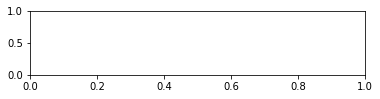

In [ ]:
t = np.linspace(0,100,10000)
t = t[:3000]

plt.subplot(3, 1, 1)
plt.plot(t[:-test_size], sol[:-test_size, 0], 'r', label='x')
plt.plot(t[-test_size :], preds[-test_size :,0], '-b', label='predicted_x')
plt.show()
plt.subplot(3, 1, 2)
plt.plot(t[:-test_size], sol[:-test_size, 1], 'g', label='y')
plt.plot(t[-test_size :], preds[-test_size :,1], '-b', label='predicted_x')

plt.show()
plt.subplot(3, 1, 3)
plt.plot(t[:-test_size], sol[:-test_size, 2], 'y', label='z')
plt.plot(t[-test_size :], preds[-test_size :,2], '-b', label='predicted_x')

plt.show()

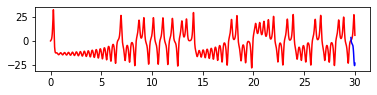

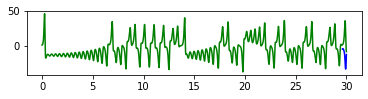

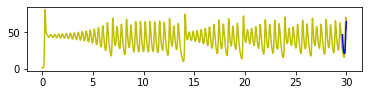

In [ ]:
t = np.linspace(0,100,10000)

plt.subplot(3, 1, 1)                # nrows=2, ncols=1, index=1
plt.plot(t[3000:-test_size], sol[3000:-test_size, 0], 'r', label='x')
plt.plot(t[-test_size :], preds[-test_size :,0], '-b', label='predicted_x')
plt.show()
plt.subplot(3, 1, 2)
plt.plot(t[3000:-test_size], sol[3000:-test_size, 1], 'g', label='y')
plt.plot(t[-test_size :], preds[-test_size :,1], '-b', label='predicted_y')

plt.show()
plt.subplot(3, 1, 3)
plt.plot(t[3000:-test_size], sol[3000:-test_size, 2], 'y', label='z')
plt.plot(t[-test_size :], preds[-test_size :,2], '-b', label='predicted_z')

plt.show()

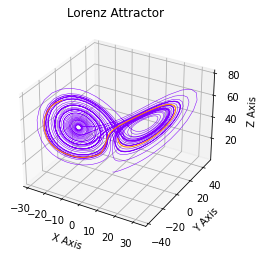

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*train_set[:-window_size].T,'#8000ff', lw =0.5)
ax.plot(*preds.T, '#ff8000', lw =1)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()